### Setup

Pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/requirements.txt) and check software and hardware.

In [ ]:
%pip install ultralytics==8.0.139

In [1]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.139 🚀 Python-3.10.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
Setup complete ✅ (32 CPUs, 251.6 GB RAM, 222.3/294.2 GB disk)


### Inference with Yolov8

Objects only = True => No plant class in trained model 

Change to false to download/use the other model


In [2]:
import os
import json
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'herbarium_segmentation')))

import cv2
import numpy as np
from matplotlib import pyplot as plt

from ultralytics import YOLO
from download import download_yolo_model


In [17]:
img_dir = '../datasets/sample/img'

objects_only = True
if objects_only:
    model_path = '../herbarium_segmentation/models/yolo_objects_only.pt'
else:
    model_path = '../herbarium_segmentation/models/yolo_instance.pt'

download_yolo_model(path=model_path, objects_only=objects_only)

# Load a pretrained YOLOv8n model
model = YOLO(model_path)

# Run inference on the source
results = model.predict(img_dir, save=True, save_txt=True, save_conf=True)

Loading objects only instance segmentation YOLO model



image 1/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/10737.jpg: 640x448 1 ruler, 3 notes, 1 barcode, 1 stamp, 1 attachment, 21.0ms
image 2/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/110423.jpg: 640x448 1 ruler, 2 notes, 1 barcode, 1 stamp, 1 attachment, 1 color_card, 20.6ms
image 3/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/119018.jpg: 640x448 1 ruler, 2 notes, 1 barcode, 2 stamps, 1 attachment, 1 color_card, 20.5ms
image 4/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/120853.jpg: 640x448 1 ruler, 3 notes, 1 barcode, 1 stamp, 1 attachment, 20.4ms
image 5/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/12406.jpg: 640x512 2 rulers, 4 notes, 1 barcode, 2 stamps, 1 attachment, 1 color_card, 34.3ms
image 6/10 /project_ghent/github/herbarium-segmentation/notebooks/../datasets/sample/img/126194.jpg: 640x512 6 ruler

Show results (visualized with YOLO)

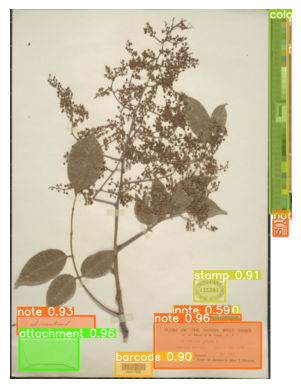

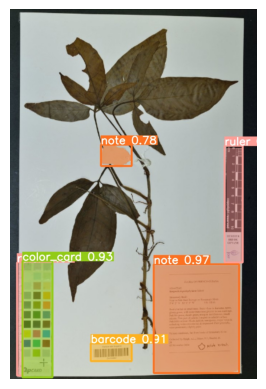

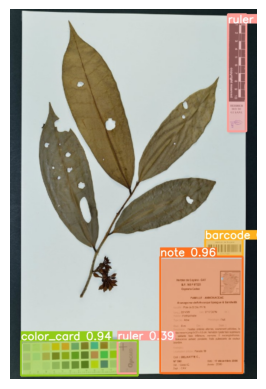

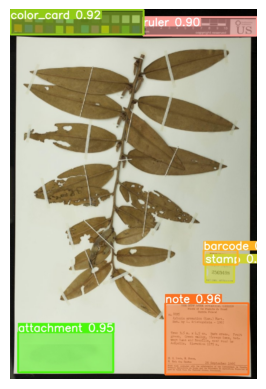

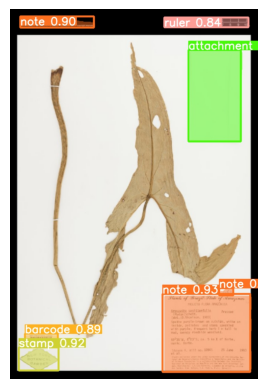

In [18]:
pred_dir = 'runs/segment/predict'

for filename in os.listdir(pred_dir)[:5]:
    if filename.endswith('.jpg'):
        img = cv2.cvtColor(cv2.imread(os.path.join(pred_dir, filename)), cv2.COLOR_BGR2RGB)
        
        plt.imshow(img)
        plt.axis('off')
        plt.show()

### Train on custom dataset

The yolo format is quite specific, so we need to convert our COCO instance dataset to it first.

The plant masks generally cannot be represented as a single polygon, so these will not be accurate.



In [ ]:
%pip install pycocotools

In [3]:
import os
import json
import pycocotools.mask as mask_utils
import numpy as np

data_dir = '../datasets/plantclef'
# change to true to ignore plant class
objects_only = False

Change iscrowd to 0 on all annotations

In [8]:
tmp_dir = 'temp'
os.makedirs(tmp_dir, exist_ok=True)

for dataset in {'train','val'}:
    fname = f'instances_{dataset}_rle_split.json'
    json_path = os.path.join(data_dir, fname)
    with open(json_path, 'r') as f:
        data = json.load(f)
        for a in data['annotations']:
            a['iscrowd'] = 0
    json_path_out = os.path.join(tmp_dir, fname)
    with open(json_path_out, 'w') as f:
        json.dump(data, f)

Filter out plant annotations if working on objects_only, ignore this if working on full dataset

In [8]:
tmp_dir = 'temp'
os.makedirs(tmp_dir, exist_ok=True)

if objects_only:
    for dataset in {'train','val'}:
        fname = f'instances_{dataset}_rle_split.json'
        json_path = os.path.join(data_dir, fname)
    
        with open(json_path, 'r') as f:
            data = json.load(f)
            new_data = data.copy()
            annos = []
            for a in data['annotations']:
                a['iscrowd'] = 0
                if a['category_id'] != 1:
                  annos.append(a)
            new_data['annotations'] = annos
        json_path_out = os.path.join(tmp_dir, fname)
        with open(json_path_out, 'w') as f:
          json.dump(new_data, f)

If Yolo gives an error for the RLE data, run below, convert to bytes and save in temporary directory

Error message: TypeError: Expected bytes, got list

In [9]:
for dataset in {'train','val'}:
    fname = f'instances_{dataset}_rle_split.json'
    json_path = os.path.join(tmp_dir, fname)

    with open(json_path, 'r') as f:
        data = json.load(f)
        for a in data['annotations']:
            rleObjs = mask_utils.frPyObjects(a["segmentation"], a["width"], a["height"])
            rleObjs['counts'] = rleObjs['counts'].decode('utf-8')
            #print(rleObjs)
            #print(rleObjs['counts'].decode('utf-8'))
            #print(rleObjs['counts'].encode('utf-8'))
            a['segmentation'] = rleObjs
            
    with open(json_path, 'w') as f:
      json.dump(data, f)


Convert the json files from the temporary directory

In [10]:
from ultralytics.yolo.data.converter import convert_coco

convert_coco(labels_dir='temp/', use_segments=True)

Annotations /project_ghent/github/herbarium-segmentation/notebooks/temp/instances_train_rle_split.json: 100%|██████████| 220/220 [00:28<00:00,  7.65it/s]
Annotations /project_ghent/github/herbarium-segmentation/notebooks/temp/instances_val_rle_split.json: 100%|██████████| 30/30 [00:03<00:00,  7.92it/s]


#### Copy over the labels and images from plantclef to new dir: yolo_dataset

In [11]:
import shutil

os.makedirs('yolo_dataset', exist_ok=True)

for dataset in {'train','val'}:
  
    yolo_label_dir = f'yolo_labels/labels/{dataset}_rle_split'
    # where the images are
    base_dir = os.path.join('../datasets/plantclef', dataset)

    # new image dir
    img_dir = os.path.join('yolo_dataset', dataset,'images')
    label_dir =  os.path.join('yolo_dataset', dataset,'labels')
    
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for f in os.listdir(base_dir):
        if f.endswith('.jpg'):
            old_path = os.path.join(base_dir, f)
            new_path = os.path.join(img_dir, f)
            shutil.copyfile(old_path, new_path)
    
    for f in os.listdir(yolo_label_dir):
        if f.endswith('.txt'):
            old_path = os.path.join(yolo_label_dir, f)
            new_path = os.path.join(label_dir, f)
            shutil.copyfile(old_path, new_path)


New make the yaml file

```
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../plant_instance  # dataset root dir
train: train  # train images (relative to 'path') 4 images
val: val  # val images (relative to 'path') 4 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: plant
  1: ruler
  2: note
  3: barcode
  4: stamp
  5: attachment
  6: color_card
  7: other

```

In [1]:
# Train YOLOv8n on COCO128 for 3 epochs
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8l-seg.pt')  # load a standard pretrained yolo model (recommended for training)

num_workers = 1
batch_size = 8

# Train the model
model.train(data='yolo_instance.yaml', epochs=3, imgsz=640, workers=num_workers, batch=batch_size)

New https://pypi.org/project/ultralytics/8.0.180 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.139 🚀 Python-3.10.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=yolo_instance.yaml, epochs=3, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, clas

#### Validate => will save results as coco_json files

Resulting scores are not accurate, as it uses the YOLO labels, better to use COCO to do the eval (see below).

In [4]:
# Load a model
from ultralytics import YOLO
model = YOLO('runs/segment/train/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(plots=True, save_json=True, workers=num_workers, batch=batch_size)  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.139 🚀 Python-3.10.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11172MiB)
YOLOv8l-seg summary (fused): 295 layers, 45918056 parameters, 0 gradients
val: Scanning /project_ghent/github/herbarium-segmentation/notebooks/yolo_dataset/val/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [04:09<00:00, 62.30s/it]
                   all         30        250      0.955       0.87      0.934      0.791      0.946      0.862      0.916      0.698
                 plant         30         34      0.919      0.971      0.976      0.878      0.891      0.941      0.944      0.608
                 ruler         30         29      0.991      0.586      0.757       0.55      0.991      0.586      0.706      0.495
                  note         30         83      0.961      0.

#### Evaluate via COCO





In [2]:
import os
import json

import numpy as np

data_dir = '../datasets/plantclef'

# Take val file with only non-plant objects
if objects_only:
    gt_json_path = os.path.join(data_dir, 'objects_val_rle_split.json')
else:
    gt_json_path = os.path.join(data_dir, 'instances_val_rle_split.json')

filename2id = {}

with open(gt_json_path,'r') as f:
  gt_anns = json.load(f)

for i in gt_anns['images']:

  fname = i['file_name'].replace('.jpg','')
  filename2id[fname] = i['id']

**Yolo category IDs start from 0 => add + 1 for each**

Yolo predictions saved the image filename as image_id, which is incorrect. Change and validate with COCO

Change runs/segment/val2/ to where yolo saved your results (see above validation code output)


In [3]:
pred_path = 'runs/segment/val2/predictions.json'
new_pred_path  = 'temp/predictions_yolo_fixed.json'

with open(pred_path,'r') as f:
  preds = json.load(f)

for p in preds:

  fname = str(p['image_id'])
  p['image_id'] = filename2id[fname]
  p['category_id'] = p['category_id'] + 1

with open(new_pred_path,'w') as f:
  json.dump(preds,f)

Now do the eval (below results are for sample model trained for 3 epochs)

To get Bbox scores, change iouType to 'bbox'

In [6]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

pred_path = new_pred_path

# Load the ground truth COCO object
coco_gt = COCO(gt_json_path)

# Load the predictions COCO object
coco_pred = coco_gt.loadRes(pred_path)

# Create a COCOEval object for evaluation
coco_eval = COCOeval(coco_gt, coco_pred, iouType='segm')

coco_eval.params.imgIds = sorted(coco_gt.getImgIds())


# Evaluate on the dataset
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.57s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Now the eval per category

In [7]:
categories_path = os.path.join(data_dir, 'panoptic_herbaria_categories.json')
with open(categories_path,'r') as f:
    categories = json.load(f)
# Get category ids
cat_ids = coco_gt.getCatIds()


# Iterate over categories
for cat_id in cat_ids:
  # Create a COCO eval object
  coco_eval = COCOeval(cocoGt=coco_gt, cocoDt=coco_pred, iouType='segm')
  print('Category id:',cat_id,[c['name'] for c in categories if c['id']==cat_id])
  # Evaluate on a per-image basis
  coco_eval.params.imgIds = sorted(coco_gt.getImgIds())
  # Set the category to evaluate
  coco_eval.params.catIds = [cat_id]

  # Run the evaluation
  coco_eval.evaluate()
  coco_eval.accumulate()
  coco_eval.summarize()

Category id: 1 ['plant']
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.784
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 